In [1]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
import torch
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,81819,0,0,0,0,0,0,0,3,0,...,0,0,0,0,1,0,0,0,0,Class_1
1,52877,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,Class_3
2,76874,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,5,2,2,Class_2
3,23007,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Class_2
4,31906,0,0,0,11,0,0,0,5,0,...,1,0,0,0,0,0,0,2,0,Class_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,96783,0,0,0,4,0,0,2,0,20,...,0,0,0,0,0,0,0,0,0,Class_4
79996,51898,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,1,0,Class_2
79997,1492,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,2,0,Class_4
79998,90984,5,0,0,0,0,0,11,2,2,...,0,0,0,0,0,0,0,0,0,Class_2


In [4]:
def calc_weight(train):
    col_name = train.columns[3]
    class_cnt = np.array(train.groupby('target').agg('count')[col_name])
    
    entropy_weight = torch.Tensor(np.exp(np.sum(np.log2(class_cnt))/np.log2(class_cnt)))
    entropy_weight = entropy_weight.cuda()
    return entropy_weight
def add_features(df):
    df.drop(['id'], axis=1, inplace=True)
    # for i,col in enumerate(df.columns):
        # df[col].loc[df[col]==np.inf]=0
        # df[col].loc[df[col]==-np.inf]=0
        # df[col] = pd.cut(df[col],bins = 16,labels = range(16))
        # df[col+str(1)] = pd.cut(df[col],bins = 8,labels = range(8))
        # df[col+str(2)] = df[col]*df[col]
        # df[col+str(3)] = df[col+str(2)]*df[col]
        # df[col+'log'] = np.log(df[col])

    
    # for i in [2,8,16,24,32,48,64]:
    #     km = KMeans(n_clusters=i,random_state=42)
    #     cluster = km.fit_predict(df)
    #     df['Cluste'+str(i)] = cluster

    df.fillna(0)
from sklearn.preprocessing import StandardScaler
def prepare_data(train, test):
    entropy_weight = calc_weight(train)
    target = train['target']
    target = np.array(target.map({"Class_1":0, "Class_2":1, "Class_3":2, "Class_4":3}))
    train.drop('target', axis=1, inplace=True)
    
    add_features(train)
    add_features(test)
    scaler = StandardScaler()
    train = pd.DataFrame(np.array(scaler.fit_transform(train)))
    test = pd.DataFrame(np.array(scaler.transform(test)))
    

    
    return train, test, target, entropy_weight

train,test,target,entropy_weight = prepare_data(train, test)

In [5]:
entropy_weight = entropy_weight*entropy_weight

In [6]:
entropy_weight

tensor([6145.4512, 1311.0331, 2711.7688, 4287.8228], device='cuda:0')

In [7]:
train = np.array(train)
test = np.array(test)

In [8]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import torch.nn as nn
criteria = nn.CrossEntropyLoss(weight=entropy_weight)

clf = TabNetClassifier(
    
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-4)
    )  #TabNetRegressor()

Device used : cuda


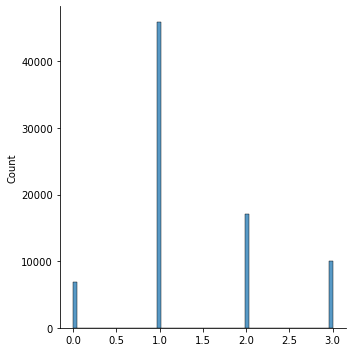

In [9]:
sns.displot(target)

In [10]:

clf.fit(
  train, 
  target,
  loss_fn = criteria,
  eval_set=[(train, target)],
  patience = 32
  
)
preds = clf.predict(test)

epoch 0  | loss: 1.63722 | val_0_accuracy: 0.31494 |  0:00:15s
epoch 1  | loss: 1.62214 | val_0_accuracy: 0.32748 |  0:00:30s
epoch 2  | loss: 1.61172 | val_0_accuracy: 0.32884 |  0:00:44s
epoch 3  | loss: 1.58733 | val_0_accuracy: 0.3474  |  0:00:58s
epoch 4  | loss: 1.56953 | val_0_accuracy: 0.34804 |  0:01:13s
epoch 5  | loss: 1.56009 | val_0_accuracy: 0.35388 |  0:01:27s
epoch 6  | loss: 1.55014 | val_0_accuracy: 0.36359 |  0:01:42s
epoch 7  | loss: 1.53587 | val_0_accuracy: 0.36391 |  0:01:56s
epoch 8  | loss: 1.52981 | val_0_accuracy: 0.37249 |  0:02:11s
epoch 9  | loss: 1.51511 | val_0_accuracy: 0.37948 |  0:02:25s


In [ ]:
preds = clf.predict(train)

In [ ]:
sklearn.metrics.accuracy_score(target, preds)

0.5568875

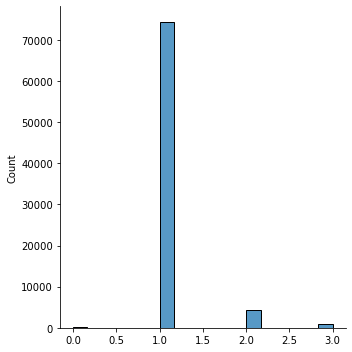

In [ ]:
sns.displot(preds)

In [ ]:
train

array([[-0.27719705, -0.2172619 , -0.21898824, ..., -0.26205264,
        -0.3783679 , -0.33136693],
       [ 0.80671535, -0.2172619 , -0.21898824, ...,  1.06727817,
         0.01057937, -0.33136693],
       [-0.27719705, -0.2172619 , -0.21898824, ...,  3.06127438,
         0.39952663,  0.85592922],
       ...,
       [-0.27719705, -0.2172619 , -0.21898824, ..., -0.26205264,
         0.39952663, -0.33136693],
       [ 5.14236496, -0.2172619 , -0.21898824, ..., -0.26205264,
        -0.3783679 , -0.33136693],
       [-0.27719705, -0.2172619 , -0.21898824, ..., -0.26205264,
        -0.3783679 , -0.33136693]])